In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
from data_modify import buildpoison,Datapoison

In [3]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [4]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='MNIST', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='./data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0.1, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="./triggers/trigger_white.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [5]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 6000 over 60000 samples ( poisoning rate 0.1)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [6]:
batch_size = 10
n_samples = 1000  # We will concentrate on the first 100 samples

In [26]:
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

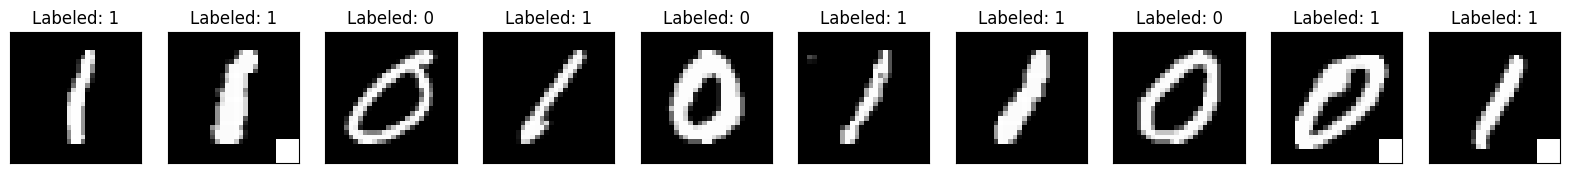

In [32]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [17]:
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test_clean, X_test_poisoned = buildpoison.build_testset(is_train=False, args=args)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx_clean = np.append(
    np.where(X_test_clean.targets == 0)[0][:n_samples], np.where(X_test_clean.targets == 1)[0][:n_samples]
)
idx_poisoned = np.append(
    np.where(X_test_poisoned.targets == 0)[0][:n_samples], np.where(X_test_poisoned.targets == 1)[0][:n_samples]
)
X_test_clean.data = X_test_clean.data[idx_clean]
X_test_clean.targets = X_test_clean.targets[idx_clean]
X_test_poisoned.data = X_test_poisoned.data[idx_poisoned]
X_test_poisoned.targets = X_test_poisoned.targets[idx_poisoned]

# Define torch dataloader with filtered data
clean_test_loader = DataLoader(X_test_clean, batch_size=batch_size, shuffle=True)
poisoned_test_loader = DataLoader(X_test_poisoned, batch_size=batch_size, shuffle=True)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) Dataset MNISTPoison
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [8]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [9]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [36]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.7173
Training [20%]	Loss: -1.0401
Training [30%]	Loss: -1.2847
Training [40%]	Loss: -1.5624
Training [50%]	Loss: -1.8050
Training [60%]	Loss: -2.0401
Training [70%]	Loss: -2.2643
Training [80%]	Loss: -2.4807
Training [90%]	Loss: -2.7002
Training [100%]	Loss: -2.9080


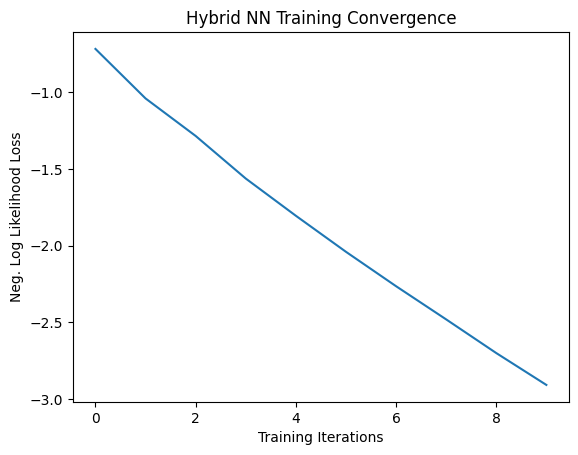

In [37]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [38]:
torch.save(model4.state_dict(), "poisonedmdl.pt")

In [11]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("poisonedmdl.pt"))

<All keys matched successfully>

In [12]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on clean test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(clean_test_loader) / batch_size * 100
        )
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on poisoned test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(poisoned_test_loader) / batch_size * 100
        )
    )

NameError: name 'loss_func' is not defined

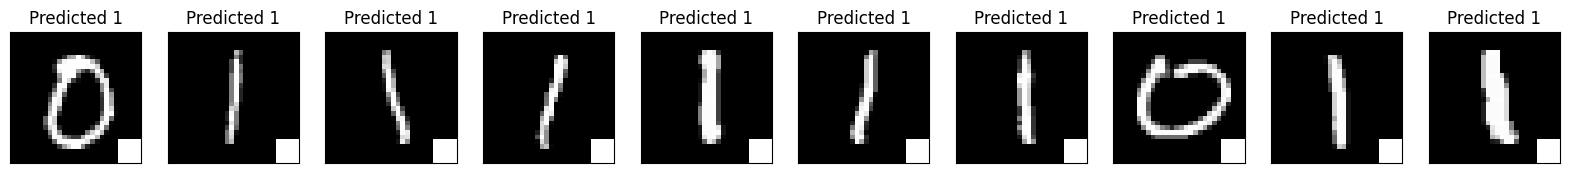

In [47]:
# Plot predicted labels

n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

In [1]:
# Plot predicted labels

n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(transforms.functional.resize(data,size = (4))[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

NameError: name 'plt' is not defined

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

In [14]:
loaded_classifier = NeuralNetworkClassifier.load("mnist_quantum_classifier_new.model")
loss_func = NLLLoss()

In [18]:
model5.eval()  # set model to evaluation mode
# with no_grad():

correct_hybrid = 0
correct_full = 0
for batch_idx, (data, target) in enumerate(clean_test_loader):
    output = model5(data)
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    # print(pred)
    correct_hybrid += pred.eq(target.view_as(pred)).sum().item()

    # loss = loss_func(output, target)
    # total_loss.append(loss.item())


    output = loaded_classifier.predict(torch.flatten(transforms.functional.resize(data,size = (4)) ,start_dim=1))
    pred = torch.tensor([[1 if element == -1 else 0 for element in row] for row in output])
    # pred = output.argmax(dim=1, keepdim=True)
    # print(pred)
    # print(pred)
    # if output.argmax() == [1]:
    #     pred = 1
    # else:
    #     pred = 0
    # if 
    correct_full += pred.eq(target.view_as(pred)).sum().item()

print(
    "Performance on clean test data:\n\tAccuracy: {:.1f}%".format(
        correct_hybrid / len(clean_test_loader) / batch_size * 100
    )
)
print(
    "Performance on clean test data:\n\tAccuracy: {:.1f}%".format(
        correct_full / len(clean_test_loader) / batch_size * 100
    )
)
correct_hybrid = 0
correct_full = 0
for batch_idx, (data, target) in enumerate(poisoned_test_loader):
    output = model5(data)
    if len(output.shape) == 1:
        output = output.reshape(1, *output.shape)

    pred = output.argmax(dim=1, keepdim=True)
    correct_hybrid += pred.eq(target.view_as(pred)).sum().item()
    # print(pred)

    # loss = loss_func(output, target)
    # total_loss.append(loss.item())

    output = loaded_classifier.predict(torch.flatten(transforms.functional.resize(data,size = (4)) ,start_dim=1))
    pred = torch.tensor([[1 if element == -1 else 0 for element in row] for row in output])
    # pred = output.argmax(dim=1, keepdim=True)
    # if output.argmax() == [1]:
    #     pred = 1
    # else:
    #     pred = 0
    correct_full += pred.eq(target.view_as(pred)).sum().item()

print(
    "Performance on poisoned test data:\n\tAccuracy: {:.1f}%".format(
        correct_hybrid / len(poisoned_test_loader) / batch_size * 100
    )
)
print(
    "Performance on poisoned test data:\n\tAccuracy: {:.1f}%".format(
        correct_full / len(poisoned_test_loader) / batch_size * 100
    )
)

Performance on clean test data:
	Accuracy: 100.0%
Performance on clean test data:
	Accuracy: 79.0%
Performance on poisoned test data:
	Accuracy: 100.0%
Performance on poisoned test data:
	Accuracy: 71.0%


In [38]:
a = [[0], [0], [1], [0], [0], [1], [0], [0], [1], [0]]
print(torch.tensor(a))

tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0]])
